# Intuitions on Convolutions

Let's build intuitions about these **`convolution operations`**.

**Goals**
- `Compute` convolution operations
- `Visualize` 
    - convolution kernels
    - the effects of a convolution kernel applied on images

<hr>

**Convolutional Neural Networks are Neural Networks specifically designed to work on images**. 

This is made possible thanks to **`convolutions`**.

These specific mathematical operations apply a **`kernel`** to an input image and creates an output representation. The name of this **`output`** can change depending on the community. Here, let's talk about the output as the **`output of a layer`**, as in standard NN models. But for CNNs, it can also be called :
* a **`"convoluted representation/feature"`**,
* or a **`"convolution"`**,
* or also an **`"activation"`** (as it corresponds to the activation of a given layer).

<img src="convolution.png" width="300">

⚠️ It is important to understand that **the same kernel, i.e. the same weights, are applied to different zones of the images**. 

⚠️ This is completely different from Dense Neural Networks that we've been working with.
* Indeed, in `Dense/"Fully Connected" Neural Network`, each weight of each neuron is related to only one input coordinate (which in this case would be each pixel).
* Here in a `Convolution Neural Network`, the weights of a kernel are not applied to only one input, i.e. one pixel, but to different pixels, "step by step" !

👉 You can think of each kernel (or each filter in the case of colored images) as a **`magnifying glass`** through which you see the image. Similarly to your eyes, kernels cannot capture everything in a picture at once, but they ***scan different parts of a picture before understanding the whole picture which is being analyzed***.

🎬 So let's have a closer look at `convolution operations`, and their impact in `Convolutional Neural Networks`.

## The dataset

❓ First use the following function to load the data:

⚠️ Do not change anything !

⚠️ Restrict from any desire to change the shapes or types of the outputs! This will have an impact on further questions.

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib.pyplot import imread

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    nb_circles = 100
    nb_triangles = 100
    
    X, y = [], []
    
    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        X.append(imread(c_path)[:, :, :1])
        y.append(0)
    
    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        X.append(imread(t_path)[:, :, :1])
        y.append(1)
        
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
        
    return np.array(X), np.array(y)
        
X, y = load_data("data")


❓ Check the shape of your data. Especially, why an additional dimension of size 1 for X?

In [2]:
# YOUR CODE HERE
# car les images sont en noir et blanc, donc il y a un canal au lieu de 3 pour la couleur.
print(X.shape)
print(y.shape)

(200, 76, 78, 1)
(200,)


❓ Do the input images need some normalization? ❓

No, car les tableaux ne contiennent que des 0 et des 1. On peut presque dire que les données sont déjà normalisées.

❓ Display some images with `plt.imshow` and their respective labels (the images are black and white, therefore use `cmap=gray` in the dedicated matplotlib function - otherwise, you will get unrelevant and weird colors).

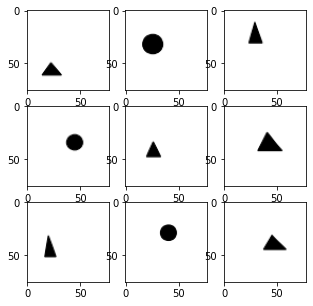

In [3]:
# YOUR CODE HERE
x_samples = X[:9]
fig, ax = plt.subplots(3, 3, figsize=(5, 5))
ax = ax.ravel()
for i in range(9):
  # squeeze permet d'ignorer la dernière dimention
    ax[i].imshow(x_samples[i].squeeze(), cmap='gray')
plt.show()

❓ How many classes are we going to predict are there? 



In [4]:
# YOUR CODE HERE
# 2 classes
y

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1])

# Part 1. Kernels

The following function performs a **`convolution operation`**, i.e. **it applies a kernel to an image**.

⚠️ Be careful ! 
* A "_convolution_ operation" in CNN is different from a "_convolution_ operation" in Signal Preprocessing. 
* For instance, the `numpy.convolve` function does NOT compute the convolution in the Deep Learning - CNN sense.

⚠️ Another warning, this `compute_convolution` is simplified:
* Convolutions are a bit more complex as they also involve `padding` and `strides`. 

⚠️ Vocabulary: 
* "Convolution" sometimes refers to _one_ operation. 
* It can also refer to the  convolution operations repeated on the entire image.
* When you are dealing with convolutions, make sure to align with your classmates/colleagues on what you are talking about.

❓ Load the function and go through the lines to understand what it is doing.

In [5]:
def compute_convolution(img, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(img) # Removes dimensions of size 1
    img_height, img_width = img.shape
    
    array = []

    for x in range(img_height-kernel_height):
        arr = []
        
        for y in range(img_width - kernel_width):
            
            a = np.multiply(img[x:x+kernel_height, y:y+kernel_width], kernel)
            arr.append(a.sum())
            
        array.append(arr)
        
    return array

❓ Apply the `compute_convolution`  with the following kernel to any image from the input dataset. 

* Display both the input image and output image
* Do you see differences ?

In [6]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

In [7]:
X[0]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [8]:
# YOUR CODE HERE
compute_convolution(X[0], identity_kernel)

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0

The previous kernel corresponds to the **`identity_ kernel`**, meaning that the output is equal to the input... It basically does nothing to the input image. You can easily figure this out by thinking about the operation it does on the image : only one pixel per convolution operation is kept as the other are multiplied by 0.

❓ `plot_convolution` with the following `kernel_1`, once on an triangle and once on a circle.

In [9]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''
    
    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)
    
    plt.figure(figsize=(10, 5))
    
    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')
    
    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')    
    
    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')    

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    plt.show()

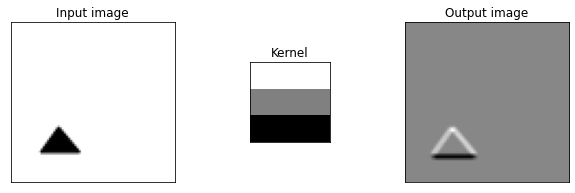

In [10]:
# YOUR CODE HERE
plot_convolution(X[0], kernel_1, activation=False)

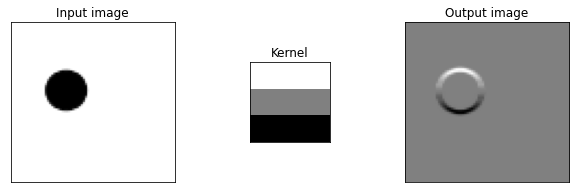

In [11]:
plot_convolution(X[1], kernel_1, activation=False)


❓ Let's try to understand why this is meaningful. First, white colors correspond to high values and black to low values. In a neural network, just after a regular neuron or a convolution, there is an activation function. When the activation function is a relu, it just correponds to setting the negative values to 0.

Well, let's see what it means in the case of a CNN. Re-run the previous functions with activation set to True (in this case, the activation fuction is the relu)..

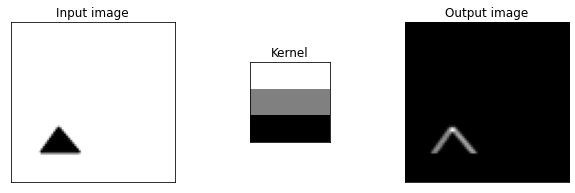

In [12]:
# YOUR CODE HERE
plot_convolution(X[0], kernel_1, activation=True)

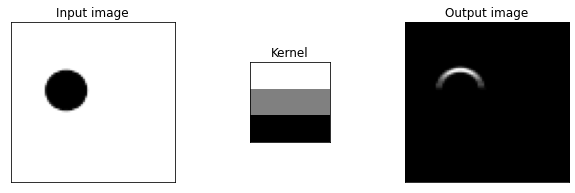

In [13]:
plot_convolution(X[1], kernel_1, activation=True)

❓ This kernel is actually highlighting the edges in a given direction. 

* Try the following kernels to check the different edges it can detect.

In [14]:
kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],   
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

# YOUR CODE HERE

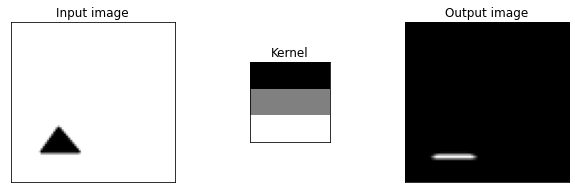

None


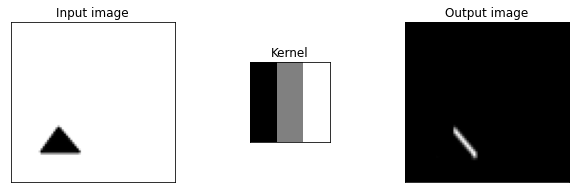

None


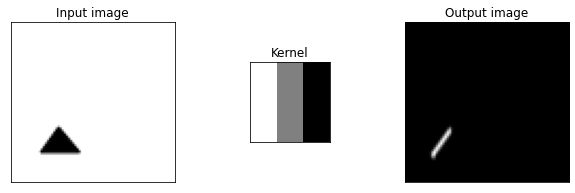

None


In [15]:
# YOUR CODE HERE
print(plot_convolution(X[0], kernel_2, activation=True))
print(plot_convolution(X[0], kernel_3, activation=True))
print(plot_convolution(X[0], kernel_4, activation=True))

❓ **What is the `effect of kernel size`**? 

👇 Check it out with a larger kernel of shape (10,10) down below:

In [16]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])
# YOUR CODE HERE

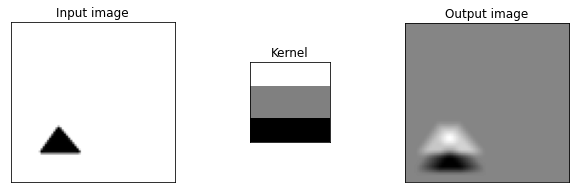

None


In [17]:
print(plot_convolution(X[0], kernel_big, activation=False))

❓ Feel free to try any other kernel

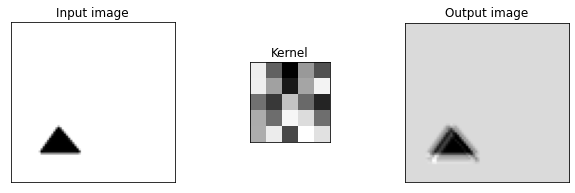

None


In [18]:
random_kernel = np.random.uniform(-10, 10, (5, 5))
# YOUR CODE HERE
print(plot_convolution(X[0], random_kernel, activation=True))

Now that you've got the idea of what a convolution operation does to an image, let's see how it goes with a "real" Convolutional Neural Network.

# Part 2. Convolutional Neural Network


❓ Write a convolutional network that has 
- a Convolutional Layer with 16 filters with (4, 4) kernels.
- a Convolutional Layer with 32 filters with (3, 3) kernels.
- a Convolutional Layer with 32 filters with (3, 3) kernels.
- a Convolutional Layer with 32 filters with (2, 2) kernels.

with:
- A Max-Pooling Layer (with a (2, 2) pool-size) after each convolution.
- A Hidden Dense Layer with the size of your choice, be reasonable:
    - after the flattening part 
    - but before the last layer


Also, make sure to compile your model with the adequate parameters

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split


def initialize_model():
# YOUR CODE HERE

    model = models.Sequential()
    ### First convolution & max-pooling
    model.add(layers.Conv2D(16, kernel_size=(4,4), input_shape= (76,78, 1), activation = 'relu'))
    # To complete
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Second convolution & max-pooling
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'))
    # To complete
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Third convolution & max-pooling
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'))
    # To complete
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Forth convolution & max-pooling
    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    # To complete
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())
    # To complete

    ### One fully connected
    model.add(layers.Dense(64, activation = 'relu'))
    # To complete

    ### Last layer (let's say a classification with 10 output)
    model.add(layers.Dense(1, activation = 'sigmoid'))
    # To complete
    
    ### Model compilation
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= 'adam')
    # To complete
    return model


❓ Fit the model. You should achieve a accuracy of at least 90. Here, the point is not to bother with overfitting, so do not worry much as you would have to if you have a high score.

In [20]:
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=5)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(y_test.shape)

(140, 76, 78, 1)
(60, 76, 78, 1)
(140,)
(60,)


In [21]:
# YOUR CODE HERE
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model= initialize_model()

model.fit(X_train, Y_train, batch_size=16, epochs=20, callbacks=[callback], validation_split=0.3)

Epoch 1/20
7/7 [==============================] - 2s 81ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.0000e+00 - val_accuracy: 0.3095
Epoch 2/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.0000e+00 - val_accuracy: 0.3095
Epoch 3/20
7/7 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.0000e+00 - val_accuracy: 0.3095
Epoch 4/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.0000e+00 - val_accuracy: 0.3095
Epoch 5/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.0000e+00 - val_accuracy: 0.3095
Epoch 6/20
7/7 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.0000e+00 - val_accuracy: 0.3095
Epoch 7/20
7/7 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 0.6020 - val_loss: 0.000

## Kernels

🔥 It is possible to **`retrieve the values of the different kernels in the CNN`**. 

👍 First, remember that for a Sequential Neural Network (Convolutional or Dense), you can:
- print the `.summary()` to display the layers and the number of weights/parameters involved
- access the differents `.layers` of your model

❓ Print the different layers of your CNN model.

In [22]:
# YOUR CODE HERE
model.layers

❓ Print the summary of your CNN model.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 75, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 35, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0

❓ **Question** ❓
Have a look at the following method that returns the `values/weights of a kernel` depending on:
- the `layer number`, 
    - which can be only `0 `, `2`, `4` or `6` as , as we used 4 `Conv2D - convolutional layers`, each of them followed by a `MaxPool2D` layer
- the `kernel number`
- the `channel number`

With the following table, you will have a better overview of the different weights, kernels and filters involved in the CNN you've built earlier:

| layer_number | convolution_layer | kernel_number | channel_number |
|--------------|-------------------|---------------|----------------|
| 0            | conv2D no 1       | 16            | 1              |
| 2            | conv2D no 2       | 32            | 16             |
| 4            | conv2D no 3       | 64            | 32             |
| 8            | conv2D no 4       | 64            | 64             |





❓  Using **`plot_convolution(activation=True)`**, display some kernels from the FIRST convolutional layer, along with the activation output, to see what the model has learnt from it.

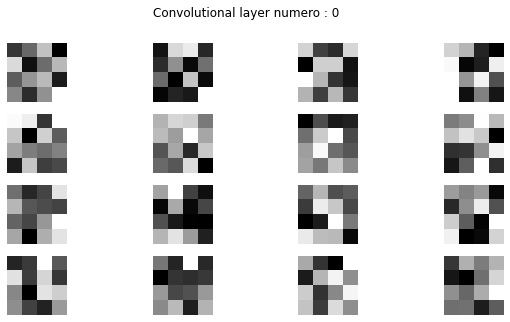

In [57]:
# First Conv2D Layer --> 16 kernels - 4x4


def display_kernel (model, layer, subplot_x, subplot_y, nb_kernel):
    # récupération des poids
    weights = model.layers[layer].get_weights()[0]

    fig, axes = plt.subplots(subplot_x, subplot_y, figsize=(10, 5))
    axes = axes.ravel()

    for i in range(nb_kernel):
        axes[i].imshow(weights[:, :, 0, i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Convolutional layer numero : " + str(layer))
    plt.show()

    
layers_number = 0 # je récupère le layer n° 0 (conv2D no 1)
nb_filters = model.layers[layers_number].filters # je récupère le nombre de filtre du layer
subplot_y = int(nb_filters / 4) # je divise par 4 pour le subplot avec le nombre de filtre (ça donnera 4 lignes de X filtres)

# avec tous les éléments du dessus, j'appelle ma fonction pour afficher les kernels
display_kernel(model, layers_number, 4, subplot_y, nb_filters)

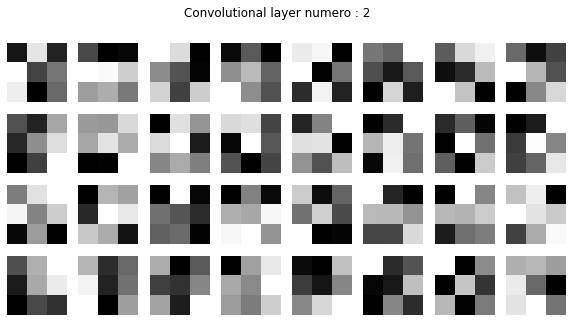

In [58]:
# Second Conv2D Layer --> 32 kernels - 3x3 
layers_number = 2 
nb_filters = model.layers[layers_number].filters 
subplot_y = int(nb_filters / 4) 

display_kernel(model, layers_number, 4, subplot_y, nb_filters)



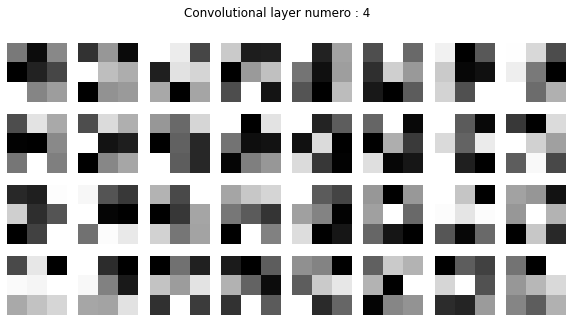

In [59]:
# Third Conv2D Layer --> 64 kernels - 3x3 
layers_number = 4 
nb_filters = model.layers[layers_number].filters 
subplot_y = int(nb_filters / 4) 

display_kernel(model, layers_number, 4, subplot_y, nb_filters)

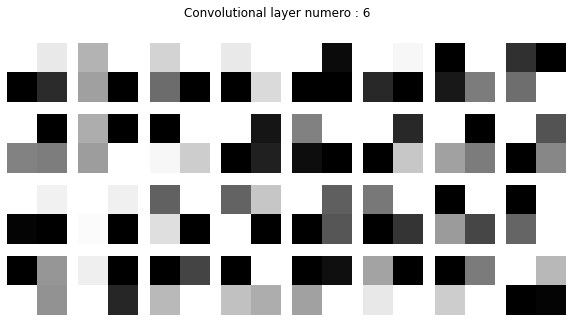

In [60]:
# Fourth/Last Conv2D Layer --> 64 kernels - 2x2
# First Conv2D Layer --> 16 kernels - 4x4
layers_number = 6 
nb_filters = model.layers[layers_number].filters 
subplot_y = int(nb_filters / 4) 

display_kernel(model, layers_number, 4, subplot_y, nb_filters)

We can also inspect the number of weights involved in our Dense layers 👇:

In [64]:
# Weights and biases of the hidden Dense layer
hidden_layer = model.get_layer("dense")
weights, biais = hidden_layer.get_weights()
print("Weight : ", weights)
print("Biais : ", biais)

Weight :  [[ 0.08732039 -0.01732069  0.11159427 ... -0.0764613  -0.002754
   0.02016547]
 [-0.05170865 -0.03434894  0.07074846 ... -0.01242162  0.02085686
   0.08484579]
 [ 0.05301821 -0.09383258  0.12199129 ... -0.05129686 -0.06246329
  -0.11183934]
 ...
 [-0.08340327 -0.08249523  0.10048529 ... -0.03160544 -0.01397407
   0.0698152 ]
 [-0.09784392  0.00119179 -0.11515422 ... -0.10651077 -0.04354642
  -0.09505342]
 [ 0.03836727 -0.06728022 -0.08667652 ... -0.01867557 -0.01176663
  -0.0842791 ]]
Biais :  [ 0.         -0.00693834 -0.00354952  0.          0.00497995 -0.00354977
  0.00689522 -0.00380753 -0.00373454  0.         -0.00548984  0.00694326
  0.0069461   0.00694322 -0.00354967 -0.00667453 -0.00693823  0.0058981
  0.00511028 -0.00354885  0.         -0.00530256 -0.00693799  0.
  0.00684614 -0.00354921 -0.00665096  0.00588384  0.00691443  0.00692669
  0.00694293  0.00694355  0.         -0.00677789  0.         -0.00473697
  0.         -0.00693925  0.00693407  0.          0.          

In [67]:
pred_layer = model.get_layer("dense_1")
weights, biases = pred_layer.get_weights()
print("Poids", weights)
print("Bais", biases)

Poids [[-0.04869315]
 [ 0.1525139 ]
 [ 0.12231727]
 [-0.29501075]
 [-0.0612544 ]
 [ 0.28861263]
 [-0.05469033]
 [ 0.09051832]
 [-0.00223318]
 [ 0.16400117]
 [ 0.21478866]
 [-0.23673622]
 [-0.23345716]
 [-0.25065652]
 [ 0.2854876 ]
 [ 0.02009873]
 [ 0.14899328]
 [-0.27346656]
 [-0.02885698]
 [ 0.08382639]
 [-0.06356804]
 [ 0.12940177]
 [ 0.13494104]
 [ 0.13391   ]
 [-0.14173485]
 [ 0.26522636]
 [ 0.21435525]
 [-0.25897956]
 [-0.08702789]
 [-0.25245327]
 [-0.31012538]
 [-0.2173272 ]
 [-0.2785419 ]
 [ 0.08981892]
 [-0.13189466]
 [ 0.17120291]
 [ 0.17503473]
 [ 0.21086279]
 [-0.30584514]
 [-0.14396125]
 [ 0.00317881]
 [-0.2675247 ]
 [-0.18465108]
 [-0.03701091]
 [-0.15604936]
 [ 0.06424728]
 [-0.14271887]
 [ 0.22090863]
 [ 0.03482394]
 [ 0.20504463]
 [-0.26293457]
 [ 0.05854322]
 [-0.1144126 ]
 [ 0.26219025]
 [-0.01047224]
 [ 0.14097583]
 [-0.3096447 ]
 [ 0.14920336]
 [-0.179451  ]
 [ 0.13138443]
 [-0.19159457]
 [-0.30260885]
 [ 0.03162605]
 [ 0.01051791]]
Bais [-0.00694159]


But let's focus our attention on the **`convolutional layers`** a.k.a. **`Conv2D`** !

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 75, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 35, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0

In [71]:
def get_kernel(layer_number, kernel_number, channel_number):

    weight_or_bias = 0
    k = model.layers[layer_number].weights[0].numpy()[:,
                                                      :,
                                                      channel_number,
                                                      kernel_number]

    return k


# YOUR CODE HERE
get_kernel(0, 2,0)

array([[ 0.09923415, -0.0677807 , -0.09095916,  0.10245434],
       [-0.14090532,  0.09444533,  0.09473753, -0.1203175 ],
       [ 0.14985007,  0.06521602, -0.08226822, -0.11603763],
       [ 0.06453016, -0.06953364,  0.06890878, -0.07937767]],
      dtype=float32)

---------------------------------------------------------------------------------
 
 
The original picture had 1 channel...
... and we created 16 outputs using 16 kernels...
What are the outputs of those 16 kernels applied to our image ?
 
 
------------------------- Effect of the kernel number 0 -------------------------


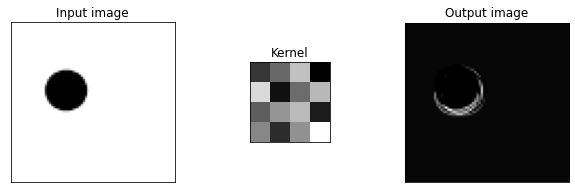

------------------------- Effect of the kernel number 1 -------------------------


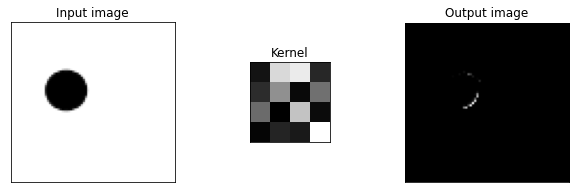

------------------------- Effect of the kernel number 2 -------------------------


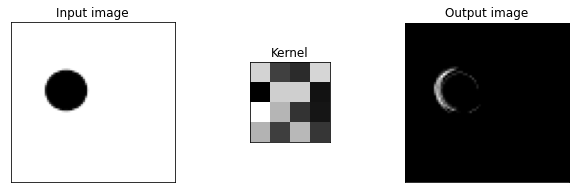

------------------------- Effect of the kernel number 3 -------------------------


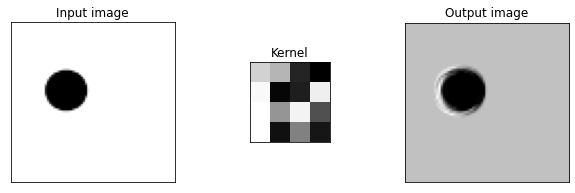

------------------------- Effect of the kernel number 4 -------------------------


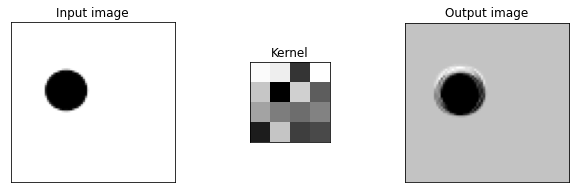

------------------------- Effect of the kernel number 5 -------------------------


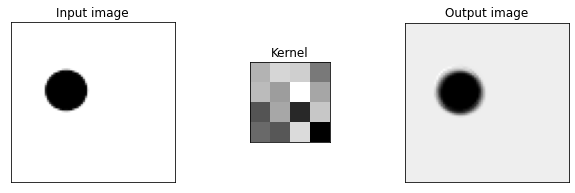

------------------------- Effect of the kernel number 6 -------------------------


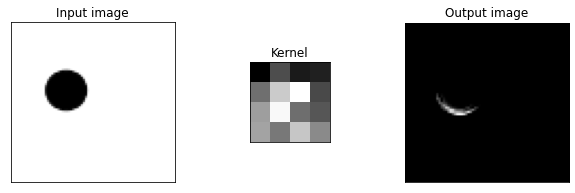

------------------------- Effect of the kernel number 7 -------------------------


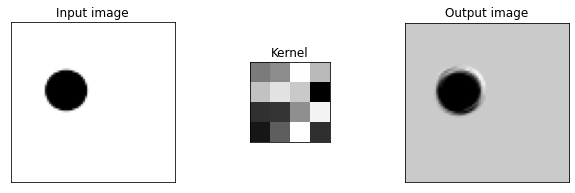

------------------------- Effect of the kernel number 8 -------------------------


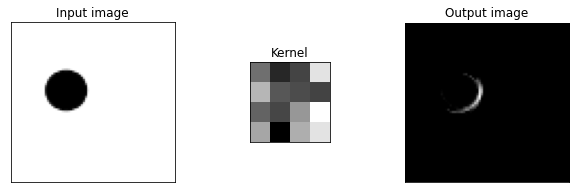

------------------------- Effect of the kernel number 9 -------------------------


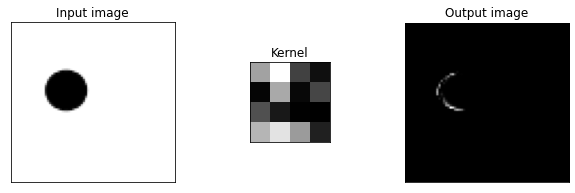

------------------------- Effect of the kernel number 10 -------------------------


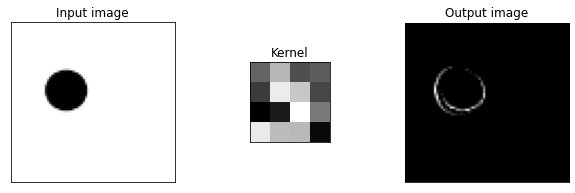

------------------------- Effect of the kernel number 11 -------------------------


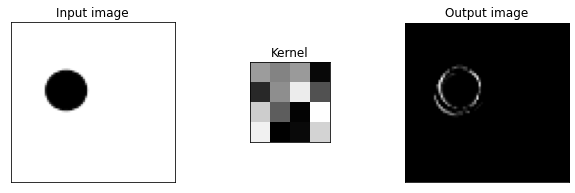

------------------------- Effect of the kernel number 12 -------------------------


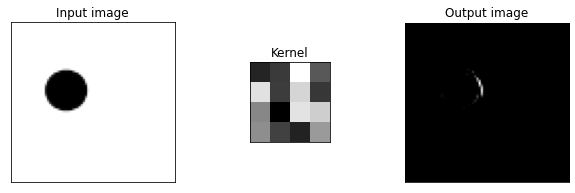

------------------------- Effect of the kernel number 13 -------------------------


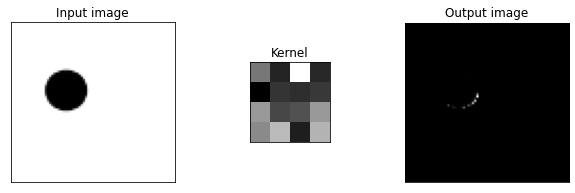

------------------------- Effect of the kernel number 14 -------------------------


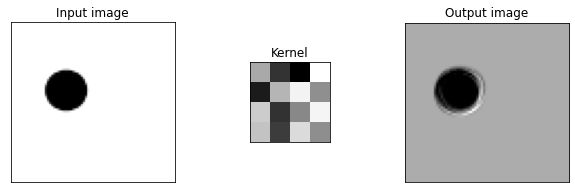

------------------------- Effect of the kernel number 15 -------------------------


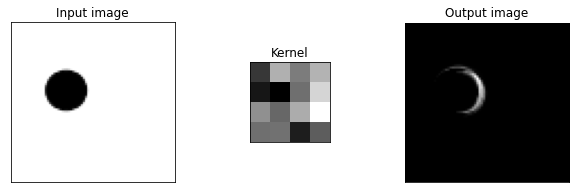

In [72]:
print("-" * 81)
print(" ")
print(" ")

print("The original picture had 1 channel...")
print("... and we created 16 outputs using 16 kernels...")
print("What are the outputs of those 16 kernels applied to our image ?")

print(" ")
print(" ")

for i in np.arange(0,16):
    print(f"------------------------- Effect of the kernel number {i} -------------------------")
    kernel = get_kernel(0, i, 0)
    plot_convolution(X[1], kernel, activation=True)

## Activations

* 👀 We have been looking at the activation ("`output image`") of the **first layer** only.


* 🤔 What if we want to **visualize the activation of the CNN after the second convolutional layer** ?
    1. We need to compute the activations after the first layer, 
    2. then run the MaxPooling operation
    3. and eventually the  second convolution operations
    
  🥵 Quite a tedious process, right ?

😇 Have a look at the cell down below, we provided you with a **`function to retrieve an activation`** based on :
* the *`image_number`*
* the *`layer_number`*
* the *`kernel_number`*

🎁 It computes the different activations through the entire network and store them in a list

💡 *Remark*: It uses the  `tensorflow.keras` `Fonctional API` syntax!

❓ Run the following cells step by step:

**Step 1 : list all the layers' outputs of your CNN**

In [73]:
# List all the layers outputs
#layers_outputs
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 73, 75, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 36, 37, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 34, 35, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 17, 17, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 15, 15, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 7, 7, 32) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 6, 6, 32) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 3, 3, 32) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 288) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>]

* There are `4 (Conv2D, MaxPooling2D)` couples which represent $ 4 \times 2 = 8 $ layers
* Followed by :
    * a `Flatten Layer`
    * a `Hidden Layer`
    * a `Prediction Layer`
    
In total, we have 11 layers, hence 11 layers' outputs.

Among these 11 layers, 4 are Convolutional Layers.

In [75]:
len(layer_outputs)

11

**Step 2: Instantiate 11 sub-models**

In [87]:
# Instanciate 11 sub-models: [layer1, layer1-->layer2, layer1-->layer2-->layer3, ...]
# Re-using already trained weights and biases
instanciate = models.Model(model.input,layer_outputs)
instanciate

**Step 3: Compute the outputs of each submodel**

In [93]:
# Compute the 11 outputs of each sub-model
activations=instanciate.predict(X_test)
activations

2/2 [==============================] - 0s 16ms/step


[array([[[[0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          ...,
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469]],
 
         [[0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          [0.00706704, 0.        , 0.        , ..., 0.        ,
           0.37097526, 0.00428469],
          ...,
          [0.00706704, 0.        , 0.        , ..., 0.        ,
   

**Let's wrap this process into a `get_activation` function** !

🎁 We already wrote the function for you: this function helps you get the activation after any layer, based on :
* the `image_number` of the dataset
* the `layer_number`
* the `kernel_number`

In [91]:
def get_activation(activations, image_number, layer_number, kernel_number):
    '''return activation map for a given layer, image, and kernel number'''
    return activations[layer_number][image_number][:, :, kernel_number]

❓ **Questions** ❓ 

* Choose one image
* Display the activation "images" of each convolutional layer. 
    * Pick for instance the first kernel of each convolutional layer. 
    
***Notes***
1. Notice how the information of an image **flows** through the Convolutional Neural Network.
2. You should see the picture becoming more and more "abstract", of smaller and smaller "dimensions"

In [94]:
#Displayer layers
activation_list = []
for layer_number in [0,1,2,3,4,5,6,7]:
    activation = get_activation(activations, 0, layer_number, 1)
    activation_list.append(activation)
activation_list

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0.23458488, 0.23458488, 0.23458488, ..., 0.23458488, 0.23458488,
         0.23458488],
        [0.23458488, 0.23458488, 0.23458488, ..., 0.23458488, 0.23458488,
         0.23458488],
        [0.23458488, 0.23458488, 0.23458488, ..., 0.23458488, 0.23458488,
         0.23458488],
        ...,
        [0.23458488, 0.23458488, 0.23458488, ..., 0.23458488, 0.23458488,
         0.23458488],
        [0.23458488, 0.23458488, 0.23458488, ..., 0.23458488, 0.23458488,
 

In [95]:
print(f"We have {len(X)} images: 100 triangles and 100 circles")

We have 200 images: 100 triangles and 100 circles


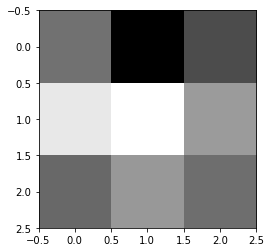

In [96]:
plt.imshow(activation, cmap='gray')

--- Observing the effect of the convolution layer number 1... ---

16 kernels were applied and here are all the activations of this Conv2d Layer:


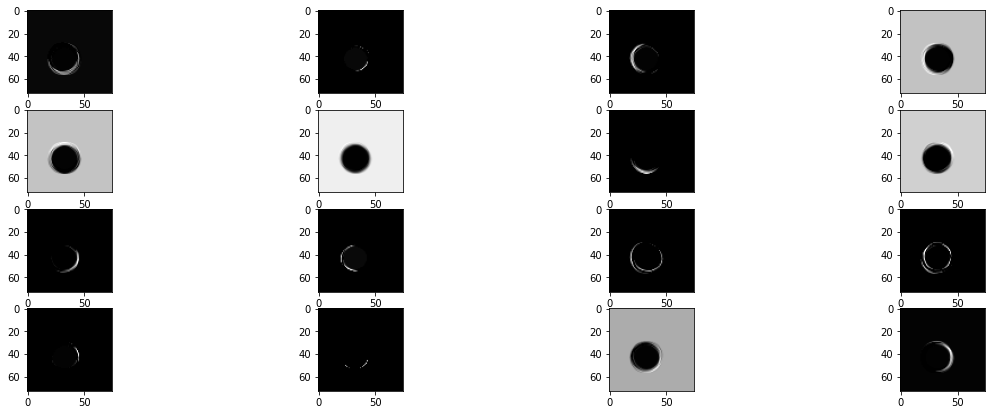

--- Observing the effect of the convolution layer number 2... ---

32 kernels were applied and here are all the activations of this Conv2d Layer:


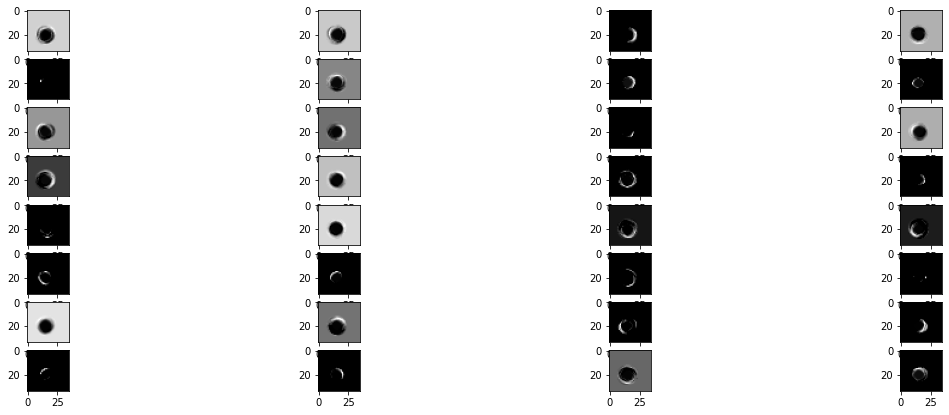

--- Observing the effect of the convolution layer number 3... ---

32 kernels were applied and here are all the activations of this Conv2d Layer:


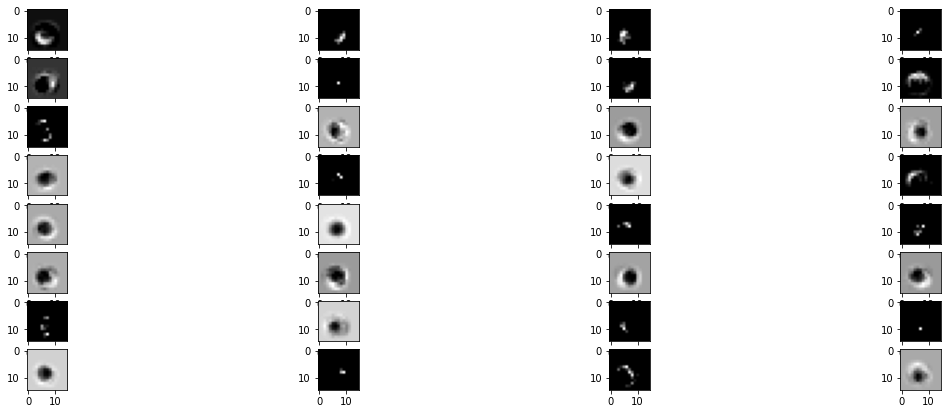

--- Observing the effect of the convolution layer number 4... ---

32 kernels were applied and here are all the activations of this Conv2d Layer:


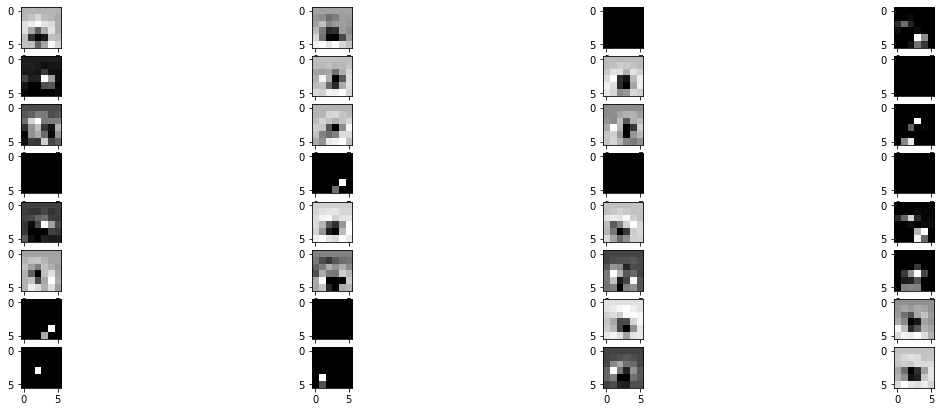

In [97]:
image_number = 3

convolution_layer_number = 1

for layer_number in [0,2,4,6]:
    print(f"--- Observing the effect of the convolution layer number {convolution_layer_number}... ---")
    print("")
    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2d Layer:")
    
    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))
    
    
    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = get_activation(activations, 
                                    image_number=image_number, 
                                    layer_number=layer_number, 
                                    kernel_number=kernel_number)
        ax.imshow(activation, cmap="gray")
    
    plt.show()

    convolution_layer_number += 1


🏁 **Congratulations!**


## Utils (Appendix)

* The following section simply presents the functions that helped us create the dataset with triangles and circles you have been working with.

* They were left at the end of the notebook just in case you want to further prototype and get better understanding of what is going on. 

* But skip this section and go to the next exercise as for now, and come back to it any time later.

In [98]:
def draw_triangle():
    dx = np.random.uniform(0.1, 0.3)
    dy = np.random.uniform(0.1, 0.3)
    noise_x = np.random.uniform(0.0, 0.1)
    noise_y = np.random.uniform(0.0, 0.1)    
    
    x = np.random.uniform(0, 1-dx-noise_x)
    y = np.random.uniform(0, 1-dy)
    X = np.array([[x,y], [x+dx+noise_x,y], [x+dx/2, y+dy+noise_y]])

    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)
    
def draw_circle():
    r = np.random.uniform(0.1, 0.25)
    x = np.random.uniform(0+r, 1-r)
    y = np.random.uniform(0+r, 1-r)

    circle1 = plt.Circle((x, y), r, color='black')
    plt.gcf().gca().add_artist(circle1)
    
def create_image(form, path):
    plt.figure(figsize=(1, 1))
    if form == 'circle':
        draw_circle()
    elif form == 'triangle':
        draw_triangle()
    plt.axis('off')
    plt.savefig(path, dpi=80, bbox_inches='tight')
    plt.close()

    
def create_images(path):
    nb_circles = 100
    nb_triangles = 100
    
    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        create_image('circle', c_path)
        
    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        create_image('triangle', t_path)